In [1]:
import torch
import torchvision
from torchvision import transforms

from dist_ae import SetAutoencoderGNN, SetAutoencoderHybrid, train_w_stop
from losses import sliced_wasserstein_distance, sinkhorn, mmd

from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def sample_mnist_sets(n_sets, set_size):
    # load mnist dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.view(-1))])
    dataset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    
    # group indices by label
    label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}
    
    sets = []
    metadata = []
    for _ in range(n_sets):
        label = torch.randint(0, 10, (1,)).item()  # random label
        indices = torch.randperm(len(label_to_indices[label]))[:set_size]  # sample set_size images
        sets.append(dataset.data[label_to_indices[label][indices]].float().view(set_size, -1) / 255.0)
        metadata.append(label)  # store label info
    
    return torch.stack(sets).float(), metadata

In [3]:
set_size = 100
N_sets = 10**3

mnist_sets, _ = sample_mnist_sets(N_sets, set_size)
train_loader = torch.utils.data.DataLoader(mnist_sets, 
                                           batch_size=32, shuffle=True)

mnist_sets, _ = sample_mnist_sets(N_sets, set_size)
val_loader = torch.utils.data.DataLoader(mnist_sets, 
                                           batch_size=32, shuffle=False)

def loss_fn(X, Y):
    return torch.vmap(sliced_wasserstein_distance, randomness='different')(X, Y).mean()

dist_ae = SetAutoencoderHybrid(mnist_sets.shape[2], 32, 128, set_size)
optimizer = torch.optim.Adam(dist_ae.parameters(), lr=5e-4)

dist_ae = train_w_stop(dist_ae, optimizer, train_loader, val_loader, 
                       loss_fn, max_epochs=400, patience=15)

/tmp/ipykernel_1589929/319726545.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}


Epoch 1 | Train Loss: 0.2686 | Val Loss: 0.1564
Epoch 2 | Train Loss: 0.1451 | Val Loss: 0.1422
Epoch 3 | Train Loss: 0.1380 | Val Loss: 0.1357
Epoch 4 | Train Loss: 0.1297 | Val Loss: 0.1235
Epoch 5 | Train Loss: 0.1162 | Val Loss: 0.1121
Epoch 6 | Train Loss: 0.1037 | Val Loss: 0.0983
Epoch 7 | Train Loss: 0.0961 | Val Loss: 0.0929
Epoch 8 | Train Loss: 0.0920 | Val Loss: 0.0895
Epoch 9 | Train Loss: 0.0875 | Val Loss: 0.0860
Epoch 10 | Train Loss: 0.0850 | Val Loss: 0.0834
Epoch 11 | Train Loss: 0.0827 | Val Loss: 0.0829
Epoch 12 | Train Loss: 0.0816 | Val Loss: 0.0805
Epoch 13 | Train Loss: 0.0799 | Val Loss: 0.0799
Epoch 14 | Train Loss: 0.0787 | Val Loss: 0.0779
Epoch 15 | Train Loss: 0.0771 | Val Loss: 0.0763
Epoch 16 | Train Loss: 0.0754 | Val Loss: 0.0749
Epoch 17 | Train Loss: 0.0740 | Val Loss: 0.0737
Epoch 18 | Train Loss: 0.0724 | Val Loss: 0.0723
Epoch 19 | Train Loss: 0.0710 | Val Loss: 0.0707
Epoch 20 | Train Loss: 0.0699 | Val Loss: 0.0694
Epoch 21 | Train Loss: 0.0689

In [4]:
test_sets, metadata = sample_mnist_sets(1000, set_size)
with torch.no_grad():
    z, rec = dist_ae((test_sets).float().cuda())

/tmp/ipykernel_1589929/319726545.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_to_indices = {i: torch.where(torch.tensor(dataset.targets) == i)[0] for i in range(10)}


In [5]:
umap = UMAP(n_components=2)
vis = umap.fit_transform(z.cpu().numpy())

/home/gokulg/.conda/envs/metaMI/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


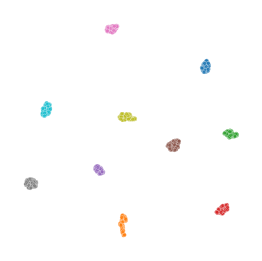

In [6]:
fig = plt.figure(figsize=(2,2), dpi=150)
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], hue=metadata, s=3, alpha=0.7,
                palette='tab10', legend=False)
plt.axis('off')
plt.show()

In [7]:
from sklearn.decomposition import PCA

def pca_means(mnist_sets, n_components=16):
    n_sets, set_size, dims = mnist_sets.shape
    flat_data = mnist_sets.view(-1, dims)  # flatten sets into a single batch

    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(flat_data)  # get principal components

    pcs = pcs.reshape(n_sets, set_size, -1)  # restore set structure
    return pcs.mean(axis=1)  # mean over each set

pca_means_res = pca_means(test_sets)


In [8]:
vis = umap.fit_transform(pca_means_res)

/home/gokulg/.conda/envs/metaMI/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


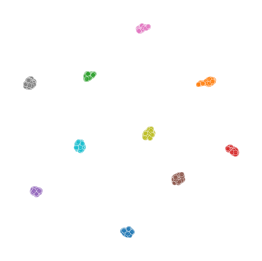

In [9]:
fig = plt.figure(figsize=(2,2), dpi=150)
sns.scatterplot(x=vis[:, 0], y=vis[:, 1], hue=metadata, s=5, alpha=0.7,
                palette='tab10', legend=False)
plt.axis('off')
plt.show()

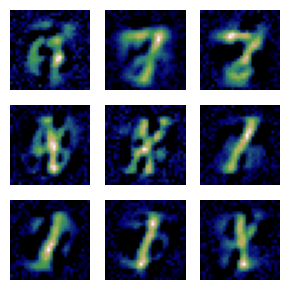

In [10]:
def plot_grid(rec, n_rows=3, n_cols=3):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    for i in range(n_rows):
        for j in range(n_cols):
            axes[i, j].imshow(rec[i][j].reshape(28, 28).cpu().numpy(), 
                              cmap="gist_earth", vmin=0)
            axes[i, j].axis("off")  # remove axis for cleaner look
    plt.tight_layout()
    plt.show()

plot_grid(rec)